# Jupyter Notebook Delft FEWS User Day 2019

### by Lindsay Millard, Hydrologist Seqwater



## Overview

Jupyter Notebooks are fast way to develop and trial code for Delft FEWS adapters
visit:
https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks
to learn more about Jupyter Notebooks
Bring to your particular attention the 
####  Pandas for Data Analysis 
Example notebooks - such as Timeseries Analysis


Let start off by calling the following Python modules to run the code in this example. Most are standard libraries within a Python installation. <br> If your Anaconda Distribution (or vanilla Python) does not have it then you can use either conda or pip to install them.

Command Line >>> Pip install 'missing module'


In [153]:
from xml.etree.ElementTree import *  # Import everything 

import time
from datetime import datetime
import csv
import os

## from xlsxwriter.workbook import Workbook

import numpy as np
import pandas as pd  ## Abbreviate it using the convention
pd.options.display.date_dayfirst=True  # Important to some assumptions below

# Check what version of the module you are running, lets check Pandas.
pd.__version__

%matplotlib inline

You can set up functions for checking the currency of the file found in the system path.  
This needs to be run before the main part of the code

In [107]:
## Worker Function for checking currency
def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

# It is a good idea to put your variables up front
fewsNamespace="http://www.wldelft.nl/fews/PI"

# The working folder root path can be defined here and then built on later when looking for files or output paths
regionHome = r'W:\500_Reference\530_Presentations\04_FEWS User Conference - Australia\2019\Python_LinguaFrancaofFEWS\GoldSim/'

regionHome = r'C:\Users\lmillard\GitRepos\DFUDA_2019_Adapter/'

Using For and If loops are a great way to pull data into the Python interpreter. It is probably a little confusing at first but the commentary along the way should make aspects a little clearer. If it doesn't make sense it can be unwrapped into a simple example. 

# Part 1 _ Pre-Adapter

In [108]:
# This is a list of the names of the XML files to go look for. I.e. look in regionHome for import.xml
XMLs = ['importState','import']

for xml in XMLs:
    fin = os.path.join(regionHome,'1_Input',xml+'.xml')    
    FEWS_Export = fin   #  regionHome+'1_Input/importState.xml'

    parameterNames = ['HNPD_OUT','Reservoir.inflow.forecast', 'Reservoir.outflow.forecast', 'Gate.setting.forecast',]
    spreadsheetNames = {'Reservoir.inflow.forecast':'LakeInflows', 'Reservoir.outflow.forecast':'RegulatorFlows', 'Gate.setting.forecast':'Gates', 'HNPD_OUT':'LakeLevels'}

XMLs = ['importState']#,'import']
## This will only work one by one in a Jupyter Notebook with many cells spilting the loop

for xml in XMLs:
    print(xml)
    fin = os.path.join(regionHome,'1_Input',xml+'.xml')    
    FEWS_Export = fin   #  regionHome+'1_Input/importState.xml'

    parameterNames = ['HNPD_OUT','Reservoir.inflow.forecast', 'Reservoir.outflow.forecast', 'Gate.setting.forecast',]
    spreadsheetNames = {'Reservoir.inflow.forecast':'LakeInflows', 'Reservoir.outflow.forecast':'RegulatorFlows', 'Gate.setting.forecast':'Gates', 'HNPD_OUT':'LakeLevels'}

    for parametername in parameterNames:                   
        ParList=[]
        par =[]
        locId=[]
        i = 0    
        

importState


Here is reminder of what an XML looks like (using Grid display in XML spy)

<img src="assets/XML_timeseries.png">

Here is some code the will scrape timeseries data out of an XML file exported from FEWS.  
The header information can be dealt with first. You can retrieve the number of Series (7), ParameterId (Reservoir.inflow.forecast) and MissingValue (-999.0)

In [109]:
        with open(FEWS_Export, "r") as file:
            print('We have opended the following file:\n'+FEWS_Export)
            
            tree = parse(file)
            PItimeSeries = tree.getroot()
            
            series = PItimeSeries.findall('.//{' + fewsNamespace + '}series')
            ## Search for all the Parameters defined in the XML
            Parameters=PItimeSeries.findall('.//{' + fewsNamespace + '}parameterId')
            for param in Parameters:
                ParList.append(param.text)
            
            parCount=0  # Initialise a counter of parameters found                
            
            missingvalue = PItimeSeries.findall('.//{' + fewsNamespace + '}missVal')
            

We have opended the following file:
C:\Users\lmillard\GitRepos\DFUDA_2019_Adapter/1_Input\importState.xml


The code does not know how many timeseries are in the XML. The following code will loop through all of the parameters of interest and then count the length.  

In [110]:
            for S in series:
                events = S.findall('.//{' + fewsNamespace + '}event')
                
                # When working with Date Time we will need to define it is a DateTime not a string or float
                ArrayDates = np.zeros((len(events)),dtype='datetime64[ns]')
                
                par = S.find('.//{' + fewsNamespace + '}parameterId').text
                if par==parametername:
                    parCount = parCount + 1
            
            ## Once you loop through the file you are able to set up empty array of appropriate size            
            ArrayValues = np.zeros((len(events), parCount))
            print('Number of Timestep rows:     '+ str(ArrayValues.shape[0]))
            print('Number of Parameter columns: '+ str(ArrayValues.shape[1]))
            

Number of Timestep rows:     481
Number of Parameter columns: 0


In [111]:
            j = 0

            DateList = []
            for S in series:
                par = S.find('.//{' + fewsNamespace + '}parameterId').text
                
                if par!=parametername:
                    pass
                
                else:            
                    events = S.findall('.//{' + fewsNamespace + '}event')
                    locs = S.findall('.//{' + fewsNamespace + '}locationId')
                    
                    i=0
                    for l in locs:
                        locId.append(l.text)        
                
                    for ev in events:
                        if ev.attrib['value'] == S.find('.//{' + fewsNamespace + '}missVal').text:
                            ArrayValues[i,j] = float(0)
                        else:
                            ArrayValues[i,j] = float(ev.attrib['value'])
                        
                        strucTime_Tuple = datetime.strptime(ev.attrib['date'] + " " + ev.attrib['time'],"%Y-%m-%d %H:%M:%S")
                        ArrayDates[i] = strucTime_Tuple

                        i += 1
                    j += 1
            row = i
            col = j
            print(row,col)

            DFd = pd.DataFrame(ArrayDates) 
            # Rename the columns
            DFd.columns = ['DateTime']
            
            DFv = pd.DataFrame(ArrayValues) 
            # Rename the columns
            DFv.columns = locId
            
            # Concatenate both columns together, do this column-wise (axis=1)
            DF = pd.concat([DFd,DFv],axis=1)

0 0


In [112]:
        ## Because the list of files and parameters contradict, we need to stop it overwriting the previous loop
        if xml == 'importState' and parametername == 'HNPD_OUT':
            GoldSIMSpreadSheet = regionHome+'2_Model/'+spreadsheetNames[parametername]+'.xlsx'

            #Let us use Pandas to write the file to a spreadsheet, this can be done in one line
            DF.to_excel(GoldSIMSpreadSheet,sheet_name='FEWS_Export')
            print(parametername)

        elif parametername != 'HNPD_OUT':
            GoldSIMSpreadSheet = regionHome+'2_Model/'+spreadsheetNames[parametername]+'.xlsx'
            DF.to_excel(GoldSIMSpreadSheet,sheet_name='FEWS_Export')
            print(parametername)

print(parametername)
DF.head()           

Gate.setting.forecast
Gate.setting.forecast


,DateTime
0,1970-01-01
1,1970-01-01
2,1970-01-01
3,1970-01-01
4,1970-01-01


# Part 1 - Run the Pre- Adapter

## Run the Master For loop from the top

This will allow the file to iterate over all of the parameters and files of interest.  
This will produce the XLSX files that GoldSim requires to run


In [115]:
XMLs = ['importState','import']

for xml in XMLs:
    fin = os.path.join(regionHome,'1_Input',xml+'.xml')    
    FEWS_Export = fin   #  regionHome+'1_Input/importState.xml'

    parameterNames = ['HNPD_OUT','Reservoir.inflow.forecast', 'Reservoir.outflow.forecast', 'Gate.setting.forecast',]
    spreadsheetNames = {'Reservoir.inflow.forecast':'LakeInflows', 'Reservoir.outflow.forecast':'RegulatorFlows', 'Gate.setting.forecast':'Gates', 'HNPD_OUT':'LakeLevels'}

    for parametername in parameterNames:                   
        ParList=[]
        par =[]
        locId=[]
        i = 0    
        
        with open(FEWS_Export, "r") as file:
            tree = parse(file)
            PItimeSeries = tree.getroot()
            Parameters=PItimeSeries.findall('.//{' + fewsNamespace + '}parameterId')
            for param in Parameters:
                ParList.append(param.text)
                
            missingvalue = PItimeSeries.findall('.//{' + fewsNamespace + '}missVal')
            series = PItimeSeries.findall('.//{' + fewsNamespace + '}series')

            # determine size of aray needed. all series MUST be the same length
            parCount=0
            for S in series:
                events = S.findall('.//{' + fewsNamespace + '}event')
                ArrayDates = np.zeros((len(events)),dtype='datetime64[ns]')
                
                par = S.find('.//{' + fewsNamespace + '}parameterId').text
                if par==parametername:
                    parCount = parCount + 1
            
            ArrayValues = np.zeros((len(events), parCount))
            j = 0

            DateList = []
            for S in series:
                par = S.find('.//{' + fewsNamespace + '}parameterId').text
                
                if par!=parametername:
                    pass
                
                else:            
                    events = S.findall('.//{' + fewsNamespace + '}event')
                    locs = S.findall('.//{' + fewsNamespace + '}locationId')
                    i=0
                    for l in locs:
                        locId.append(l.text)        
                
                    for ev in events:
                        if ev.attrib['value'] == S.find('.//{' + fewsNamespace + '}missVal').text:
                            ArrayValues[i,j] = float(0)
                        else:
                            ArrayValues[i,j] = float(ev.attrib['value'])
                        
                        strucTime_Tuple = datetime.strptime(ev.attrib['date'] + " " + ev.attrib['time'],"%Y-%m-%d %H:%M:%S")
                        ArrayDates[i] = strucTime_Tuple

                        i += 1
                    j +=  1
            row = i
            col = j

            DFd = pd.DataFrame(ArrayDates) 
            DFd.columns = ['DateTime']
            DFv = pd.DataFrame(ArrayValues) 
            DFv.columns = locId

            DF = pd.concat([DFd,DFv],axis=1)
                
            
        if xml == 'importState' and parametername == 'HNPD_OUT':
            GoldSIMSpreadSheet = regionHome+'2_Model/'+spreadsheetNames[parametername]+'.xlsx'
            DF.to_excel(GoldSIMSpreadSheet,sheet_name='FEWS_Export')
        
        elif parametername != 'HNPD_OUT':
            GoldSIMSpreadSheet = regionHome+'2_Model/'+spreadsheetNames[parametername]+'.xlsx'
            DF.to_excel(GoldSIMSpreadSheet,sheet_name='FEWS_Export')




# Part 2 - Run GoldSim

The Excel spreadsheet files for the:
    Gates, LakeInflows, LakeLevels and RegulatorFlows have all been produced by Part 1.
    
Running the GoldSim Player file produces RoutedFlows.txt and RoutedLevels.txt

<img src="assets/GoldSim_RunTheTimeseries.png">

# Part 3 - Run the Post-Adapter

Using the RoutedFlows.txt and RoutedLevel.txt we can now turn them back into XML timeseries for FEWS to read

In [124]:
# populate the xml file
def xml(parameter, location, eventValues, dT64, unit):
    #sd = str(dateTime[0])
    sd = dateTime[0].strftime("%Y-%m-%d")
    st = dateTime[0].strftime("%H:%M:%S")
    ed = dateTime[-1].strftime("%Y-%m-%d")
    et = dateTime[-1].strftime("%H:%M:%S")
    DTtimeStep = dateTime[1]-dateTime[0]
    timeStep = int(DTtimeStep.total_seconds())
    
    # write XML output timeseries
    with open(regionHome+ExportXML,'a') as xf:    # 'a+b'
        
        ## Write Header for each Series 
        
        xf.write('    <series>\n')
        xf.write('        <header>\n')
        xf.write('            <type>instantaneous</type>\n')        
        
        loc_text = str('            <locationId>%s</locationId>\n') % (location)
        xf.write(loc_text)        
        
        par_text = str('            <parameterId>%s</parameterId>\n') % (parameter)
        xf.write(par_text)
        
        timestep_text = str('            <timeStep unit="second" multiplier="%s"/>\n') %(timeStep)
        xf.write(timestep_text)   
        
        sd_text = str('            <startDate date="%s" time="%s"/>\n') % (sd, st)
        xf.write(sd_text)
        
        ed_text = str('            <endDate date="%s" time="%s"/>\n') % (ed, et)
        xf.write(ed_text)
        
        xf.write('            <missVal>-999.0</missVal>\n')
        xf.write('            <stationName>Hydro Gauge 1</stationName>\n')        
        
        unit_text = str('            <units>%s</units>\n') %(unit)
        xf.write(unit_text) 
        
        xf.write('        </header>\n')
        
        
        ## Write all the event values for each  timestamp in the series
        for i in range(len(eventValues)):
            event_date = str('        <event date="%s"') % (dateTime[i].strftime("%Y-%m-%d"))
            event_time = str(' time="%s"') % (dateTime[i].strftime("%H:%M:%S"))
            event_value = str(' value="%s"') % eventValues[i][0].round(2)
            event_flag = str(' flag="0"/>\n')
            
            event = str(event_date+event_time+event_value+event_flag)
            xf.write(event)
            
        xf.write('    </series>\n')
        
    
    

## 03 _ Main Post-Adapter code

Go get the GoldSim model results and then translate the output files



In [140]:
regionHome = r'C:\Users\lmillard\GitRepos\DFUDA_2019_Adapter/'

ExportXML = '3_Output/Export_fromGoldSim.xml'
GoldSimOutputs = ['RoutedFlows.txt','RoutedLevels.txt']

DF = pd.DataFrame()

# write XML output header, once
with open(ExportXML,'w') as xf:
    xf.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    xf.write('<TimeSeries xmlns="http://www.wldelft.nl/fews/PI" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.wldelft.nl/fews/PI http://fews.wldelft.nl/schemas/version1.0/pi-schemas/pi_timeseries.xsd" version="1.2">\n')
    xf.write('    <timeZone>10.0</timeZone>\n')

for GS in GoldSimOutputs:
    fin = os.path.join(regionHome,'2_Model',GS)

    with open(fin,'r') as f:
        lines = f.readlines()
        parameter = lines[11].split()[1]
        unit = lines[12].split()[1]

    df = pd.read_table(fin,skiprows=14,header=None,names=['DateTime',parameter+'_'+unit,'Blank'],index_col=0,
                       parse_dates=True,dayfirst=True)

    df = df.drop(['Blank'],axis=1)   
    DF = pd.concat([DF,df],axis=1)
    
    locn = 'NPD'
    dateTime = df.index.to_pydatetime()
    xml(parameter,locn,df.values,dateTime,unit)

with open(ExportXML,'a') as xf:
    xf.write('</TimeSeries>\n') 


## Have a quick plot of the results

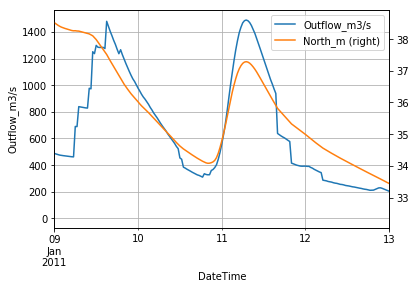

In [152]:
ax=DF.iloc[:,0].plot(legend=True)
DF.iloc[:,1].plot(secondary_y=True,
                  ax=ax,legend=True)
ax.set_ylabel(DF.columns[0])
ax.set_xlim('09-01-2011','13-01-2011')
ax.grid(which='both')